### Author: Julian Reed
#### Citations:
* Dataset: https://www.kaggle.com/crowdflower/twitter-airline-sentiment
* Dr. Z's "Complete data modelling process" referenced for binarizing data
* Fillna() for certain columns: https://www.statology.org/pandas-fillna/

In [1]:
#Import all necesary libraries
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nltk
import nltk.corpus
import pandas as pd
from wordcloud import WordCloud, STOPWORDS
from sklearn.linear_model import LogisticRegression

In [2]:
#import reviews dataset, convert it into a dataframe
df = pd.read_csv('Airline Tweets.csv')
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


Dataset Description (from Kaggle.com): A sentiment analysis job about the problems of each major U.S. airline. Twitter data was scraped from February of 2015 and contributors were asked to first classify positive, negative, and neutral tweets, followed by categorizing negative reasons (such as "late flight" or "rude service"). 

Features of the dataset:
* `tweet_id`: the unique id of each tweet
* `airline_sentiment`: sentiment of the tweet
* `airline_sentiment_confidence`: confidence in previous sentiment
* `negativereason`: the reason for the negative sentiment, NaN if positive or neutral sentiment
* `negativereason_confidence`: confidence in negative reason
* `airline`: which airline the tweet corresponds to
* `airline_sentiment_gold`: Unknown
* `name`: username of tweeter
* `negativereason_gold`: Unknown
* `retweet_count`: how many times a certain tweet was retweeted
* `text`: text of tweet
* `tweet_coord`: coordinates of each tweet
* `tweet_location`: location of tweet
* `user_timezone`: timezone of the user that created the tweet

This data that makes up this dataset was taken directly from twitter, so it represents a wide range of backrgounds, viewpoints and groups. However, the language filter on twitter, especially the filter during 2015 when this data was collected, isn't the strongest and allows for a lot of speech that would be largely considered insensitive. There isn't a clear solution to this issue as it isn't reasonable to comb through all of the text, but it is important to stay aware of this when looking at the results of the model.

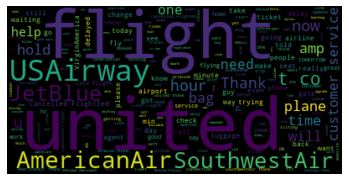

In [3]:
stopwords = set(STOPWORDS)
stopwords.update(["br", "href"])
textt = " ".join(tweet for tweet in df.text)
wordcloud = WordCloud(stopwords=stopwords).generate(textt)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

My first step for visualizing this dataset is making a wordcloud of the text from each tweet. As the wordcloud above shows, it appears that some of the most common words are flight, one, time and delayed, along with the name of major airlines. This is logical considering the dataset, and it doesn't appear that any insenstive words are a major part of that dataset at this time. 

In [4]:
df['airline'].describe()

count      14640
unique         6
top       United
freq        3822
Name: airline, dtype: object

Next, I want to fix any issues with the `airline` column, if there are any. This column will be important for testing the connection between these airlines and other words later on when my word2vec model is created. Looking at a description of the column, it appears that there are 6 different airlines, which is a logical number of airlines to be mentioned, and the highest frequency is 3822, which means that all of the airlines have a somewhat similar amount of tweets about them. However, to ensure that each airline has a sufficient amount of tweets about it, I'll take a closer look at the column and drop any rows of missing data if there are any.

In [5]:
df[df['airline'].isnull()]

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone


The above code block shows that there is no missing data in the `airline` column, which means we can keep all the rows of data for now.

In [6]:
df['airline'].value_counts()

United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: airline, dtype: int64

<BarContainer object of 6 artists>

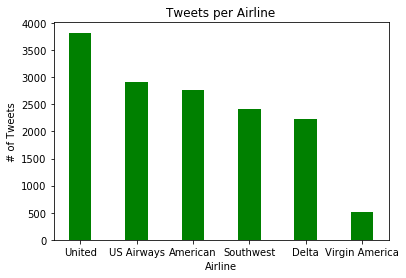

In [7]:
fig = plt.figure(figsize = (6,4))
plt.title("Tweets per Airline")
plt.xlabel("Airline")
plt.ylabel("# of Tweets")
plt.bar(['United', 'US Airways', 'American', 'Southwest', 'Delta', 'Virgin America'], [3822, 2913, 2759, 2420, 2222, 504], 
        color ='green', width = 0.4)

This bar graph shows that United and Virgin America are outliers in terms of the amounts of tweets they have about them, with United having far more and Vrigin America having far, far less. This makes sense, considering United is one of if not the biggest airlie in the world and Virgin America is a smaller one than the rest. I don't think there is anything to change here, as the column is correct in there being 6 different values, all of which are real airlines with actual data, rather than a value saying 'US Airways1' with only one tweet about it, which is good. I will just have to keep in mind that the Word2Vec model similarity for Virgin America will likely be less accurate since it has around 1/5 of the tweets that the other airlines have.

Next, I will use the `airline_sentiment` column to create a column of numerical sentiments (1, 0, -1). Before I do this, I need to check that the `airline_sentiment` column is correct and doesn't have any missing data.

In [8]:
df[df['airline_sentiment'].isnull()]

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone


In [9]:
df['airline_sentiment'].describe()

count        14640
unique           3
top       negative
freq          9178
Name: airline_sentiment, dtype: object

In [10]:
df['airline_sentiment_confidence'].describe()

count    14640.000000
mean         0.900169
std          0.162830
min          0.335000
25%          0.692300
50%          1.000000
75%          1.000000
max          1.000000
Name: airline_sentiment_confidence, dtype: float64

In [11]:
binarizer = {'positive': 1, 'neutral': 0, 'negative': -1}
df['sentiment_num'] = df.airline_sentiment.map(binarizer)
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,sentiment_num
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada),0
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada),1
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada),0
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada),-1
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada),-1


In [12]:
df['sentiment_num'].value_counts()

-1    9178
 0    3099
 1    2363
Name: sentiment_num, dtype: int64

<BarContainer object of 3 artists>

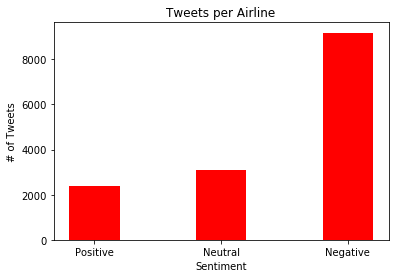

In [13]:
fig = plt.figure(figsize = (6,4))
plt.title("Tweets per Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("# of Tweets")
plt.bar(['Positive', 'Neutral', 'Negative'], [2363, 3099, 9178], 
        color ='red', width = 0.4)

Using this newly created column, it is important to first get a good understanding of the column. First, looking at the distribution, there are far more tweets with a negative sentiment than neutral, and around 1000 more neutral tweets than positive. This means that the model will likely be weaker when it comes to positive and neutral sentiment, but this  is fine as long as I keep this in mind when analyzing model results.

Now that the sentiment has been classified into numerical data, I will clean the rest of the dataset and remove any unnecessary columns:

In [14]:
df.drop('tweet_id', axis=1, inplace=True)
df.drop('airline_sentiment_gold', axis=1, inplace=True)
df.drop('name', axis=1, inplace=True)
df.drop('negativereason_gold', axis=1, inplace=True)
df.drop('retweet_count', axis=1, inplace=True)
df.drop('tweet_coord', axis=1, inplace=True)
df.drop('tweet_created', axis=1, inplace=True)
df.drop('tweet_location', axis=1, inplace=True)
df.drop('user_timezone', axis=1, inplace=True)
df.drop('airline_sentiment_confidence', axis=1, inplace=True)
df.drop('airline_sentiment', axis=1, inplace=True)
df.head()

,negativereason,negativereason_confidence,airline,text,sentiment_num
0,NaN,NaN,Virgin America,@VirginAmerica What @dhepburn said.,0
1,NaN,0.0000,Virgin America,@VirginAmerica plus you've added commercials t...,1
2,NaN,NaN,Virgin America,@VirginAmerica I didn't today... Must mean I n...,0
3,Bad Flight,0.7033,Virgin America,@VirginAmerica it's really aggressive to blast...,-1
4,Can't Tell,1.0000,Virgin America,@VirginAmerica and it's a really big bad thing...,-1


In the above code, I drop a lot of columns for the dataset, but there is a reason for each of them: 

The `tweet_id`, `airline_sentiment_gold`, `name`, `negativereason_gold`, `retweet_count`, `tweet_coord`, `tweet_created`, `tweet_location` and `user_timezone` columns are not helpful when determining sentiment, which mainly revolves around a labeled sentiment and text. 

`airline_sentiment_confidence`: This column is no longer useful because it is mainly used to determine the accuracy of the sentiment. When I took a look at this column earlier on, the avergage sentiment confidence was 90%, which is pretty high. As a result, I am generally accepting the sentiment recorded in the dataset as accurate, and therefore this column is no longer necessary.

`airline_sentiment`: This column is no longer needed now that the sentiment of each sample is defined numerically in `sentiment_num`

Dropping these columns also removes a lot of the null data, but I want to check if there is any left:

In [15]:
df[df.isnull().any(axis=1)]

,negativereason,negativereason_confidence,airline,text,sentiment_num
0,NaN,NaN,Virgin America,@VirginAmerica What @dhepburn said.,0
1,NaN,0.0,Virgin America,@VirginAmerica plus you've added commercials t...,1
2,NaN,NaN,Virgin America,@VirginAmerica I didn't today... Must mean I n...,0
6,NaN,0.0,Virgin America,"@VirginAmerica yes, nearly every time I fly VX...",1
7,NaN,NaN,Virgin America,@VirginAmerica Really missed a prime opportuni...,0
...,...,...,...,...,...
14630,NaN,NaN,American,@AmericanAir Thanks! He is.,1
14632,NaN,0.0,American,"“@AmericanAir: @TilleyMonsta George, that does...",0
14635,NaN,0.0,American,@AmericanAir thank you we got on a different f...,1
14637,NaN,NaN,American,@AmericanAir Please bring American Airlines to...,0


It appears that there are 5462 samples with empty data in at least one column. It looks like the the majority of this missing data is coming from the `negativereason` column. This isn't really a problem as these columns won't interfere with the training and testing of the sentiment analysis model. However, when using this data latter on this could be a problem, so for now let's replace all of the empty negative reason data with 'Not applicable', and the `negativereason_confidence` with 0.0.

In [16]:
df['negativereason']=df['negativereason'].fillna(value='Not applicable')
df['negativereason_confidence']=df['negativereason_confidence'].fillna(value=0.0)
df.head()

,negativereason,negativereason_confidence,airline,text,sentiment_num
0,Not applicable,0.0000,Virgin America,@VirginAmerica What @dhepburn said.,0
1,Not applicable,0.0000,Virgin America,@VirginAmerica plus you've added commercials t...,1
2,Not applicable,0.0000,Virgin America,@VirginAmerica I didn't today... Must mean I n...,0
3,Bad Flight,0.7033,Virgin America,@VirginAmerica it's really aggressive to blast...,-1
4,Can't Tell,1.0000,Virgin America,@VirginAmerica and it's a really big bad thing...,-1


In [17]:
df[df.isnull().any(axis=1)]

,negativereason,negativereason_confidence,airline,text,sentiment_num


Now that null data has been taken care of, I will clean the any columns with text so that they can be used for training the sentiment analysis model.

In [18]:
#Cleaning data
def remove_punctuation(text):
    final = "".join(u for u in text if u not in ("?", ".", ";", ":",  "!",'"', "@", "#"))
    return final
df['text'] = df['text'].apply(remove_punctuation)
df['negativereason'] = df['negativereason'].apply(remove_punctuation)
df['airline'] = df['airline'].apply(remove_punctuation)

In [19]:
positive = df[df['sentiment_num'] == 1]
negative = df[df['sentiment_num'] == -1]
neutral = df[df['sentiment_num'] == 0]

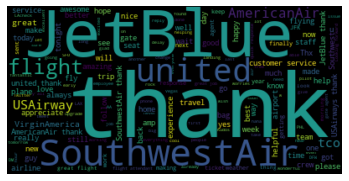

In [20]:
#Wordcloud of positive words
stopwords = set(STOPWORDS)
## good and great removed because they were included in negative sentiment
pos = " ".join(review for review in positive.text)
wordcloud2 = WordCloud(stopwords=stopwords).generate(pos)
plt.imshow(wordcloud2, interpolation='bilinear')
plt.axis("off")
plt.show()

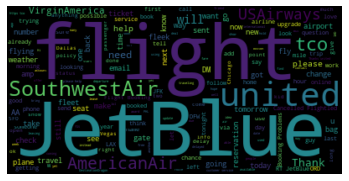

In [21]:
#Wordcloud of neutral words
neut = " ".join(review for review in neutral.text)
wordcloud2 = WordCloud(stopwords=stopwords).generate(neut)
plt.imshow(wordcloud2, interpolation='bilinear')
plt.axis("off")
plt.show()

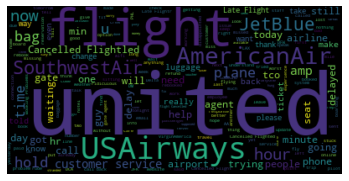

In [22]:
#Wordcloud of negative words
neg = " ".join(review for review in negative.text)
wordcloud2 = WordCloud(stopwords=stopwords).generate(neg)
plt.imshow(wordcloud2, interpolation='bilinear')
plt.axis("off")
plt.show()

In [23]:
#Create train/test split
# random split train and test data
index = df.index
df['random_number'] = np.random.randn(len(index))
train = df[df['random_number'] <= 0.8]
test = df[df['random_number'] > 0.8]

In [24]:
#convert worsd into numbers, use word2vec here in future?
# count vectorizer:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(token_pattern=r'\b\w+\b')
train_matrix = vectorizer.fit_transform(train['text'])
test_matrix = vectorizer.transform(test['text'])

In [25]:
#split target and independent variables
X_train = train_matrix
X_test = test_matrix
y_train = train['sentiment_num']
y_test = test['sentiment_num']

In [26]:
#Fit model, make preds
lr = LogisticRegression(max_iter = 500)
lr.fit(X_train,y_train)
predictions = lr.predict(X_test)

In [27]:
#print out confusion matrix and classificaion report
from sklearn.metrics import confusion_matrix,classification_report
new = np.asarray(y_test)
confusion_matrix(predictions,y_test)
print(classification_report(predictions,y_test))

              precision    recall  f1-score   support

          -1       0.89      0.85      0.87      2071
           0       0.59      0.63      0.61       607
           1       0.68      0.76      0.72       451

    accuracy                           0.80      3129
   macro avg       0.72      0.75      0.73      3129
weighted avg       0.80      0.80      0.80      3129



In [28]:
#WORD 2 VEC
#necesary imports
from nltk.tokenize import sent_tokenize, word_tokenize
import gensim
from gensim.models import Word2Vec

In [29]:
#convert each summary column into one big dataset
text_samples = df['text'].tolist()
data = []
for i in range(len(text_samples)):
    data.append(list(text_samples[i].split(" ")))

In [30]:
#create CBOW model
cbow_model = gensim.models.Word2Vec(data, min_count = 1, window = 5)

#create Skip-Gram model
sg_model = gensim.models.Word2Vec(data, min_count = 1, window = 5, sg = 1)

In [31]:
#function to print similarity between words
def print_similarity(word1, word2, model = 'both'):
    if model == 'sg':
        print(f"Cosine similarity between {word1} and {word2} - Skip-gram: {sg_model.wv.similarity(word1, word2)}")
    
    elif model == 'cbow':
        print(f"Cosine similarity between {word1} and {word2} - CBOW: {cbow_model.wv.similarity(word1, word2)}")
        
    else:
        print(f"Cosine similarity between {word1} and {word2} - CBOW: {cbow_model.wv.similarity(word1, word2)}")
        print(f"Cosine similarity between {word1} and {word2} - Skip-gram: {sg_model.wv.similarity(word1, word2)}")

In [32]:
#test similarity between two words according to models
print_similarity('flight', 'missed')
print_similarity('seat', 'change')
print(sg_model.wv.most_similar("jetblue"))
print(sg_model.wv.most_similar("virginamerica"))
print(sg_model.wv.most_similar("flight"))

Cosine similarity between flight and missed - CBOW: 0.9001997113227844
Cosine similarity between flight and missed - Skip-gram: 0.7689098715782166
Cosine similarity between seat and change - CBOW: 0.9458128809928894
Cosine similarity between seat and change - Skip-gram: 0.8010730743408203
[('united,', 0.9796100854873657), ('easily', 0.9788076281547546), ('definitely', 0.9772310256958008), ('slow', 0.9769531488418579), ('day,', 0.9763182997703552), ('seriously', 0.9752148389816284), ('nightmare', 0.9746812582015991), ('Also', 0.9743883013725281), ('solution', 0.9742557406425476), ('know,', 0.9733017086982727)]
[('copy', 0.9893860816955566), ('Imagine', 0.9891191720962524), ('I’ll', 0.9888110160827637), ('insight', 0.988746166229248), ('scavenger', 0.9885542392730713), ('credits', 0.9878343939781189), ('formal', 0.9876270890235901), ('discounts', 0.9873140454292297), ('confirming', 0.9868761897087097), ('correctly', 0.9865756034851074)]
[('flt', 0.8815504312515259), ('flight,', 0.8476507

In [ ]:
youngest25 = df['age'] < -3.729927e-02
youngest25_progression = sum(df['Progression'][youngest25]) / 111
oldest25 = df['age'] > 3.807591e-02
oldest25_progression = sum(df['Progression'][oldest25]) / 103


x = [youngest25_progression, oldest25_progression]
dataName = ['United', 'US Airways', 'American', 'Southwest', 'Delta', 'Virgin America',]
explode = [0.1, 0.1] 

plt.figure(figsize=(5,5))
plt.title("Percentage of Negative Sentiment")
plt.pie(x, explode=explode, labels=dataName, autopct='%.2f%%') 
plt.show()